In [2]:
from networkx import grid_graph
import networkx as nx
import numpy as np
import random
from matplotlib import colors, cm
import matplotlib.pyplot as plt
#%matplotlib qt
from time import sleep
import matplotlib.animation as animation
from dendropy.calculate import treemeasure
from dendropy import Tree as DTree
from io import StringIO
from random import sample, random, choice
from copy import deepcopy
from math import log
from matplotlib.animation import PillowWriter
from ete3 import Tree, NodeStyle, TreeStyle
import tqdm
from Bio import Phylo
#from plot_eteTree import plot_tree
from collections import Counter
import pandas as pd
from scipy.stats import poisson 
# Takes a genotype and converts it to an integer for use indexing the fitness landscape list 
def convertGenotypeToInt(genotype):
	out = 0
	for bit in genotype:
		out = (out << 1) | bit
	return out

# Converts an integer to a genotype by taking the binary value and padding to the left by 0s		
def convertIntToGenotype(anInt, pad):
	offset = 2**pad
	return [int(x) for x in bin(offset+anInt)[3:]]	

def flip(allele):
    if allele ==1:
        allele = 0
    else:
        allele =1
        
    return allele



In [3]:
def fitness(d,m,k,s_p,s,pk):
    p = s - s_p
    y = s + (p)* ((d**k)/((d**k)- (s-p)/s))*((m - pk)/pk)
    return y



def mutation(r,dist):
    check = np.append(dist,r)
    check.sort()
    m = np.where(check ==r )[0][0]
    return m
    
def poisson_max_cdf(x,mu,n):
    y = poisson.cdf(x,mu)**n
    return y
    
    
def sort_pairs(pair):
    # Extract integer after "r".
    return int(pair[0][1:])
   
def make_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}

    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})

                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')

    return t

def make_pruned_tree_from_list(mut_pairs):
    parents = []
    children = []
    pairs_of_mutations = []
    for item in mut_pairs:
        a = 'r'+str(item[0])
        b = 'r'+str(item[1])
        pairs_of_mutations.append((a,b))
    t = Tree() # Creates an empty tree
    r0 = t.add_child(name="r0")
    lookup = {"r0": r0}
    prune_list = ['r0']
    for pair in sorted(pairs_of_mutations, key=sort_pairs):
        parentname = pair[0]
        childname = pair[1]
        if childname not in lookup:
            if parentname in lookup:
                newchild = lookup[parentname].add_child(name = childname)
                lookup.update({childname: newchild})
                if parentname not in parents:
                    prune_list.append(lookup[parentname])
                parents.append(parentname) #make list of unique terminal nodes (no children of children)
                children.append(newchild)
            else:
                print(pair)
                raise RuntimeError('Must not happen.')
    prune_count = Counter(children)
    t.prune(prune_list)
    return t


In [52]:
def sim_user_abx(wt,ln, g,ab, mut_rate,k, s_p,s,pk,):
    
    width = wt
    length = ln
    grid_size = g
    
    ## bacteria per grid cell as mapped to MegaPLate
    bps = int(((60*((120/9)*5) * 10**8)/1)/(ln*wt))
    ##setup nx graph to find neibors quickly
    G = grid_graph(dim=[wt, ln])
    
    ##set up grid to keep track of cell state i.e. number of mutations
    cells = np.full((ln,wt),-1)
    cells[0] = 0 
    
    ##set up grid to keep track of cell state i.e. number of mutations
    muts = np.full((ln,wt),0)
    
    ##dstribution of for max of scamples drawn from poisson
    #prob_dist = poisson_max_cdf([0,1,2,3,4,5,6],mut_rate,bps)


    #new 

    t = np.linspace(0,pk,pk+1)
    poisson_unbias = poisson.pmf(t,mut_rate)
    poisson_biased=[]
    for i in np.unique(abx_grad):
        
        poisson_biased.append((poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))/(sum(poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))))
    

    
    
    
    ##set up grid that maps abx conc.  to space
    ab = ab
    
    #storing cells and mutation
    cell_history = []
    mut_pairs = []
    mut_ID = 0
    ##begin evolution
    while all(cells[-1] == -1) and len(cell_history) != 40002:
    #while all(cells[-1] == -1):
        
        ## save current state map to list
        cell_history.append(cells.tolist())
        
        
        ##find slots where there is a living cells
        cells_where =  np.where(cells != -1)
        
        
        ##create a randomized list of the living cells with which to iterate through
        cells_list = []
        for x, y in zip(cells_where[0], cells_where[1]):
            cells_list.append([x,y])
            
        np.random.shuffle(cells_list)
        
        ##decide if each living in this generation will die, live, or mutate
        for j in cells_list: 
            g_draw = 2 * random() -1
            
            ##death
            if fitness(ab[tuple(j)],cells[tuple(j)],k,s_p,s,pk) > g_draw :
                neighbors = [x for x in G.neighbors(tuple(j))]

                #find which of the neighboring cells are empty, and divide, with a daughter cell in that space
                empty = np.where(-1 == np.array([cells[tuple(x)] for x in neighbors]) )
                if len(empty[0]) != 0:
                    pick = neighbors[choice(empty)[0]]

                    #mutated daughter cells
                    #m = mutation(random(),prob_dist)
                    #m = np.random.poisson(mut_rate)
                    m = np.random.choice(t,1,p = poisson_biased[np.where(3000== np.unique(abx_grad))[0][0]])
                    
                    if m != 0:
                        mut_ID = mut_ID +1
                        mut_pairs.append([muts[tuple(j)],mut_ID])
                        cells[tuple(j)] = cells[tuple(j)]+m
                        muts[tuple(j)] = mut_ID
                    #divide
                    cells[tuple(pick)] = cells[tuple(j)]
                    
                else:
                    cells[tuple(j)] == -1


    return cell_history, mut_pairs

# Megaplate Experiment

In [16]:
%%time
##without mutation, i.e. time reflects time of bacterial 'swarm'
wd = 36
ln = 40
gr = 5

l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)


ch,mp = sim_user_abx(wt = wd,ln =ln,g= gr, ab = abx_grad,mut_rate=0,k = 1, s_p = -1,s = .1, pk= 131)

KeyboardInterrupt: 

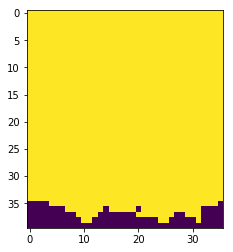

In [687]:
plt.imshow(ch[-1])

In [533]:
%%time 

ln = 20
wd = int(.9 *ln)
gr = 5

l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)

ch1,mp = sim_user_abx(wt = wd,ln =ln,g= gr, ab = abx_grad ,mut_rate=.00001,k = 7, s_p = -1,s = 1, pk= 10000)

CPU times: user 40.3 s, sys: 542 ms, total: 40.9 s
Wall time: 42.3 s


In [132]:
print('approximate swarm:experiment : ' + str(ln/len(ch1)),'maximum total mutations:' + str(np.array(ch1[-1]).max()))

approximate swarm:experiment : 0.005151983513652756 maximum total mutations:55


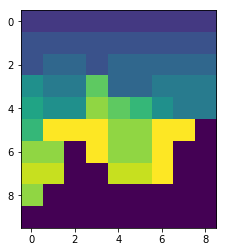

In [526]:
plt.imshow(ch1[-1])

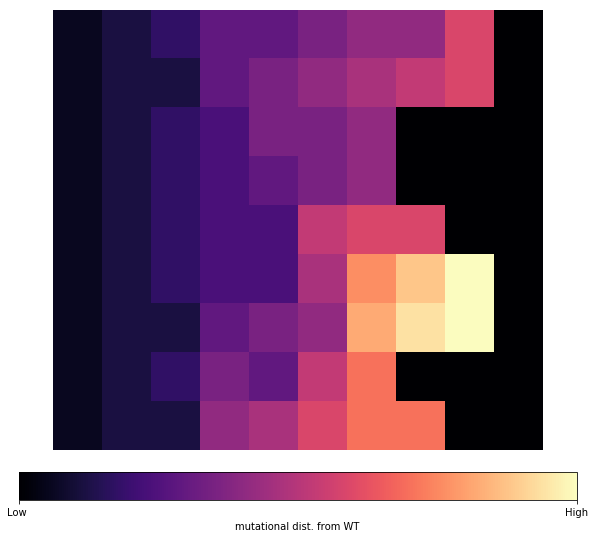

In [508]:
fig, ax = plt.subplots(figsize=(10,10))

norm = colors.Normalize(vmin = 0 ,vmax=np.array(ch1[-1]).max())
hi = ax.imshow(np.array(ch1[-1]).T, cmap='magma',norm = norm)
ax.axis('off')
cbar = fig.colorbar(hi,ax=ax, orientation = 'horizontal',pad = .04)
cbar.set_ticks([0,np.array(ch1).max()])
cbar.set_ticklabels(["Low ",'High'])

cbar.set_label("mutational dist. from WT")
plt.savefig('sim.eps', format='eps', dpi=1000)

In [535]:
t1=make_pruned_tree_from_list(mp)
hi = t1.write('newick')
handle = StringIO(hi)
t1 = Phylo.read(handle,'newick')

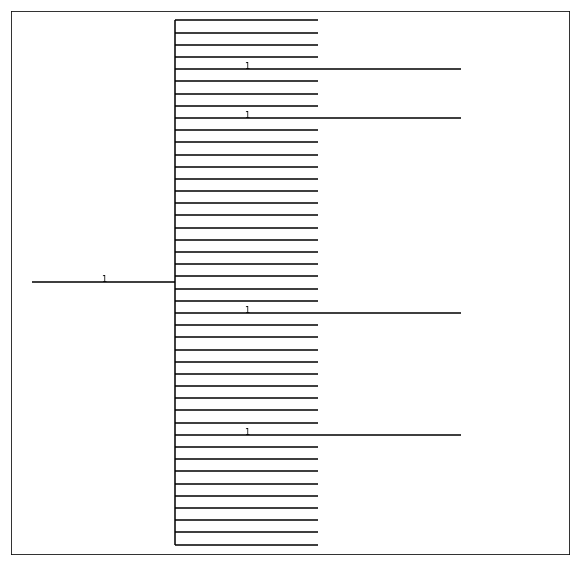

In [536]:
fig, ax = plt.subplots(figsize=(10,10))

def fn():
    return None


Phylo.draw(t1,axes=ax, label_func = lambda x: None, xlabel = ('',None), ylabel = ('',None),xticks = ([],[]),yticks = ([],[]))


In [538]:
np.array(mp).max()

264

In [485]:
ts = TreeStyle()
 
ts.show_leaf_name = False
ts.scale = 120
 
# Show branch data
ts.show_branch_length = True
ts.show_branch_support = True
 
 
# print (t.get_ascii(show_internal=True))
 
t1.show(tree_style=ts)

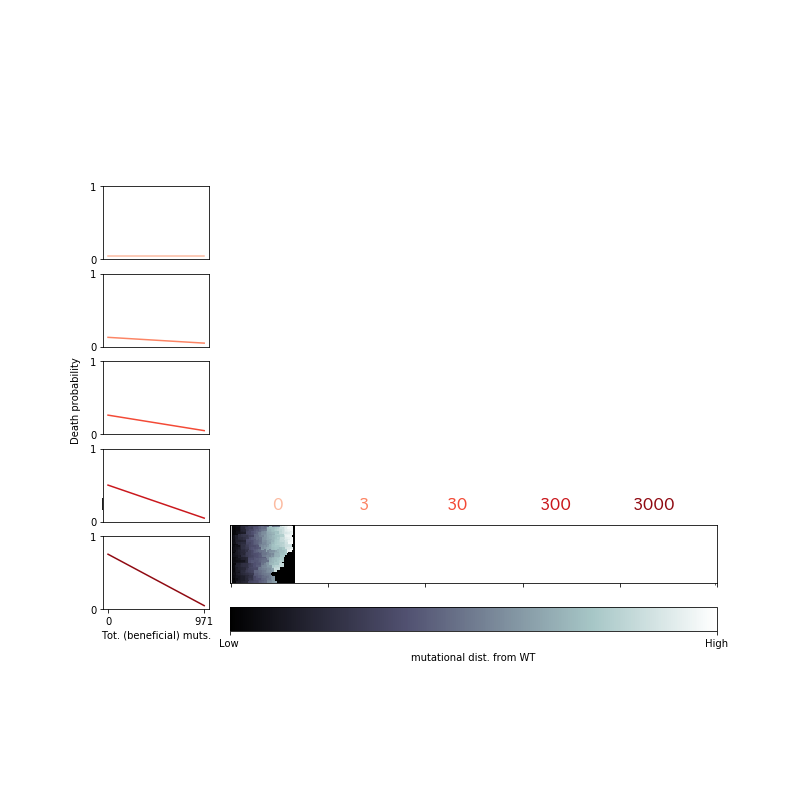

In [447]:
import matplotlib.gridspec as gridspec
fig =plt.figure(figsize=(11,11),constrained_layout=True)
gs1 =  gridspec.GridSpec(nrows=7, ncols=5)
ax1 = fig.add_subplot(gs1[:, 1:])

norm = colors.Normalize(vmin = 0 ,vmax=np.array(ch1[-1]).max())
red = plt.get_cmap('Reds')

cNorm  = colors.Normalize(vmin=0, vmax=12)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=red)

sub_axs = []
for i in range(gr):
    #sub_axs.append(fig.add_subplot(gs1[i +1, 0]))
    ax = fig.add_subplot(gs1[i+1 , 0])
    ax.set_yticks([0,1])
    plt.ylim(bottom=0,top=1)
    ax.set_xticks([])
    ax.plot(np.linspace(0,971,972),
            deathprob(np.unique(abx_grad)[i],
                      np.linspace(0,971,972),.5,1,.05,971),color = scalarMap.to_rgba(2*i+3))
    if i == gr - 1:
        ax.set_xticks([0,971])
        ax.set_xlabel('Tot. (beneficial) muts.')
    
    
    
hi = ax1.imshow(np.array(ch1[-1]).T, cmap='bone',norm = norm)


ax1.annotate('Drug conc.', xy=(70, 1), xytext=(-80, -10),fontsize=16, fontname = 'Sathu')

for i in range(len(np.unique(abx_grad))):
    
    ax1.annotate('%d' % np.unique(abx_grad)[i], xy=(70, 1), 
                 xytext=(48+ 25 * log(.4+np.unique(abx_grad)[i]), -10),
                 fontsize=16,fontname = 'Sathu',color = scalarMap.to_rgba(2*i+3))

    
cbar = fig.colorbar(hi,ax=ax1, orientation = 'horizontal',pad = .04)
cbar.set_ticks([0,np.array(ch1).max()])
cbar.set_ticklabels(["Low ",'High'])
cbar.set_label("mutational dist. from WT")

#ax1.axis('off')
ax1.set_xticklabels([])
ax1.set_xticks([299], minor=True)
ax1.set_yticks([269], minor=True)
ax1.set_xticks([i*60 for i in range(0,gr+1)])
ax1.set_yticks([])
ax1.grid(b=True, which = 'major',color='w')


shadowaxes = fig.add_subplot(111, xticks=[], yticks=[], frame_on=False)
shadowaxes.set_ylabel('Death probability', labelpad = -70)



plt.savefig('grid_diagram.eps', format='eps', dpi=1000)

As in Baym et al. Bacteria, evolve accross a large 'petri dish', in which there are rectangular zones of increasing antibiotic concentration. Each grid cell corresponds to many (i.e. millions of) bacteria. Every iteration cells may die, divide, and mutation with a given probability, determined stochastically. 

Modeled mutations are actively 'beneficial' as each mutation confers a fitness benefit - there is a linear relationship between death probability and the number of mutations a cell has. The slope of this relationship is deterimened by a pharmacodynamical model describing the relationship between fitness and drug concentration as in Regoes et al. With each generation the number of mutations a cell aquires following death is as follows: it is assumed that within all the bacteria represented by a grid cell the bacteria with the most mutations is the most fit and will outocmpete the less mutated bacteria. Hence the number of mutations is modeled as cumulative probability distribution of the maximum expected value of mutations for a sample of mutations drawn out of a poisson distriution. The size of this smaple corresponds to the amount cells in the MegaPlate that correspond to a simulation grid cell.

Taken together, the variables in this model include a constant birth rate and parameters of pharmacodyanamic model (hill coefficient, parameter describing death rate in absence of drugs, and parameter describing maximum fitness reduction due to drug). 

Here-in we demonstrate parameter sweeps with goal of estimating the mutation rate for the most highly mutable bacterial sub-clones in the experiment. Our potential estimate is contratined by the total time for the bacteria to fill the plate, the total mutations observed, and assumed maximum possible fitness reduction due to drug of 100%. 


# Parameter sweep

Here we coarsely sweep through parameters of the system to coarsely identify model parameters that correspond to  system constraints stated above. The result of this analysis will then allow for a finer parameter to estimate mutation rate

In [32]:
mut_rate = [.0008,.001,.0012,.0014]
wd = 270
ln = 300
gr = 5



l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)


k = [.5,1,2,5,]
p= 1
s = [.05,.1,.15,.2]
pk = 971
birth_rate = .95 

reps = 1
dicts_MegaPlate_coarse_971 = []
    
for a in range(reps):
    for b in range(len(mut_rate)):
        for c in range(len(k)):
            for d in tqdm.tqdm(range(len(s))):
                #for e in tqdm.tqdm(range(len(pk))):
                



                cellhistory,mut_pairs =sim_user_abx(wt = wd,ln = ln, g = gr,ab = abx_grad, 
                                                    mut_rate= mut_rate[b],k = k[c], s = s[d],
                                                    p = p, pk=pk,birth_rate = birth_rate)
                t = make_tree_from_list(mut_pairs)
                treePass = t.write(format = 1)
                DendroTree = DTree.get(data = treePass, schema = 'newick')
                size = (len([i for i in t.get_leaves()]))
                time = (len(cellhistory))
                muts = np.array(cellhistory).max()
                b1 = treemeasure.B1(DendroTree)
                n_bar = treemeasure.N_bar(DendroTree)
                sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
                dicts_MegaPlate_coarse_971.append({"mut_rate":mut_rate[b],"k":k[c],'s':s[d],"pk":pk,"size":size,"time":time,"muts":muts,
                          "n_bar":n_bar,"sackin":sackin})



100%|██████████| 4/4 [8:37:38<00:00, 9188.20s/it]


In [33]:
import shelve


# file to be used
shelf = shelve.open("dicts_MegaPlate_coarse_971.shlf")

# serializing
shelf["my_dict"] = dicts_MegaPlate_coarse_971

shelf.close()

In [7]:
import shelve

shelf = shelve.open("dicts_MegaPlate_coarse_971.shlf") # the same filename that you used before, please
dicts_MegaPlate_coarse_971= shelf["my_dict"]
shelf.close()

In [34]:
e_coli_swarmv = 40
MEGAplatesize = (120/9)*5
mp_swarm_time = MEGAplatesize*10**4/(e_coli_swarmv*3600)
mp_exp_time = 264
mp_swarm_time/mp_exp_time

0.017536475869809203

In [38]:
df_971 =  pd.DataFrame(dicts_MegaPlate_coarse_971)

df_971['time_ratio']= 200/df_971['time']
#df_971 = df_971[df_971['time_ratio'] < .02]
df_971 = df_971[df_971['muts'] > 200]



In [40]:
df_971.sort_values(by='muts')

,k,mut_rate,muts,n_bar,pk,s,sackin,size,time,time_ratio
0,0.5,0.0008,655,2.152593,971,0.05,-19.156331,64682,389,0.514139
32,0.5,0.0012,685,2.147460,971,0.05,-19.145880,64180,377,0.530504
1,0.5,0.0008,693,2.178979,971,0.10,-19.082448,63164,433,0.461894
48,0.5,0.0014,700,2.150872,971,0.05,-19.120882,63491,372,0.537634
16,0.5,0.0010,707,2.153579,971,0.05,-19.177606,65406,389,0.514139
4,1.0,0.0008,710,2.182708,971,0.05,-19.129274,64781,471,0.424628
17,0.5,0.0010,738,2.178762,971,0.10,-19.105678,63895,433,0.461894
20,1.0,0.0010,743,2.180530,971,0.05,-19.066821,62721,442,0.452489
33,0.5,0.0012,744,2.177525,971,0.10,-19.081906,63101,422,0.473934
8,2.0,0.0008,751,2.204657,971,0.05,-19.073261,63687,544,0.367647


The previous parameter sweep was done assuming essentially that the maximum possible mutations was the final mutation count in the samples of the original experiment. Relaxing this assumption, by assuming that there are many more beneficial mutations possible than that observed, and by extension assuming the sysnomouns mutations observed were all beneficial, we can do another parameter sweep with a 'steeper' fitness landscape. We can add an additional constraint by assuming the wild type and mutant strains evolve under the same fitness landsacpe, only differing in their mutations rate

In [140]:

ln = [40,120]
wd = [int(.9*i) for i in ln]

gr = 5





mut_rate = [.0001,.0005,.001]

k = [1,8]
s_p= -1
s = 1
pk = [10000,30000]


reps = 1
dicts_MegaPlate_coarse_134 = []
    
for a in range(reps): 
    for b in range(len(mut_rate)):
        for c in range(len(ln)):
            for d in range(len(k)):
                for e in tqdm.tqdm(range(len(pk))):
                    
                    l = [val for sublist in [[j for i in range(int(ln[c]/gr))] for j in range (0,gr)] for val in sublist]
                    ab =[[3*10**(i-1)]*wd[c] for i  in l if i != 0]
                    [ab.insert(i, [0]*wd[c]) for i in range(0,int(ln[c]/gr))]
                    abx_grad = np.array(ab)

                



                    cellhistory,mut_pairs =sim_user_abx(wt = int(wd[c]),ln = int(ln[c]), g = gr,ab = abx_grad, 
                                                        mut_rate= mut_rate[b],k = k[d], s_p = s_p,
                                                        s = s, pk=pk[e])
                    t = make_tree_from_list(mut_pairs)
                    treePass = t.write(format = 1)
                    DendroTree = DTree.get(data = treePass, schema = 'newick')
                    size = (len([i for i in t.get_leaves()]))
                    time = (len(cellhistory))
                    muts = np.array(cellhistory).max()
                    b1 = treemeasure.B1(DendroTree)
                    n_bar = treemeasure.N_bar(DendroTree)
                    sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
                    dicts_MegaPlate_coarse_134.append({"length":ln[c],"mut_rate":mut_rate[b],"k":k[d],'pk':pk[e],"size":size,"time":time,"muts":muts,
                              "n_bar":n_bar,"sackin":sackin})









  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:39<00:39, 39.25s/it]





100%|██████████| 2/2 [01:13<00:00, 37.68s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:55<00:55, 55.22s/it]





100%|██████████| 2/2 [03:09<00:00, 78.98s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [14:01<14:01, 841.70s/it]





100%|██████████| 2/2 [28:26<00:00, 848.70s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [09:15<09:15, 555.98s/it]





100%|██████████| 2/2 [39:02<00:00, 925.05s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:54<00:54, 54.12s/it]





100%|██████████| 2/2 [01:39<00:00, 51.60s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [00:47<00:47, 47.88s/it]





100%|██████████| 2/2 [03:33<00:00, 83.26s/it]











  0%|          | 0/2 [00:00<?, ?it/s]





 50%|█████     | 1/2 [16:18<16:18, 978.64

In [141]:
import shelve


# file to be used
shelf = shelve.open("dicts_MegaPlate_coarse_134.shlf")

# serializing
shelf["my_dict"] = dicts_MegaPlate_coarse_134

shelf.close()

In [142]:
import shelve

shelf = shelve.open("dicts_MegaPlate_coarse_134.shlf") # the same filename that you used before, please
dicts_MegaPlate_coarse_134= shelf["my_dict"]
shelf.close()

In [14]:
e_coli_swarmv = 40
MEGAplatesize = (120/9)*5
mp_swarm_time = MEGAplatesize*10**4/(e_coli_swarmv*3600)
mp_exp_time = 264
mp_swarm_time/mp_exp_time

0.017536475869809203

In [355]:
df_134 =  pd.DataFrame(dicts_MegaPlate_coarse_134)

df_134['time_ratio']= df_134['length']/df_134['time']
df_134 = df_134[df_134['time_ratio'] < .02]
#df_134 = df_134[df_134['k'] != 1 and df_134['length'] != 120]
#df_134 = df_134[df_134['mut_rate'] !=.0001]
#df_134 = df_971[df_971['muts'] > 200]



In [347]:
ln = [40,120]
wd = [int(.9*i) for i in ln]
mut_rate = [.0001,.0005,.001]
k = [1,8]
pk = [10000,30000]


/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: B

IndexError: index 18 is out of bounds for axis 0 with size 18

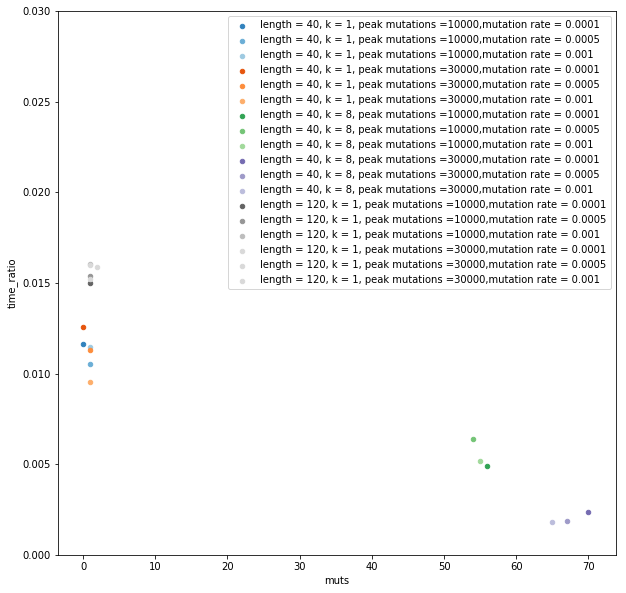

In [377]:
import seaborn as sns
fig, ax  = plt.subplots(figsize=(10,10))
ax.set_ylim(0,.03)
colors =  plt.cm.tab20c( (4/3*np.arange(24*3/4)).astype(int) )

i = 0 
for a in range(len(ln)):
    for b in range(len(k)):
        for c in range(len(pk)):
            for d in range(len(mut_rate)):
                
                
                    df_134[df_134['length']==ln[a]][df_134['k']==k[b]][df_134['pk']==pk[c]][df_134['mut_rate']==mut_rate[d]].plot('muts', 'time_ratio',legend = True,ax= ax,kind = 'scatter',
                                                                                                                             label=('length = {0}, k = {1}, peak mutations ={2},mutation rate = {3}'.format(ln[a],k[b],pk[c],mut_rate[d])),
                                                                                                                              color=colors[i])
                    i = i+1 
                                                                                                                              
            #sns.regplot(x='muts', y='time_ratio', data=df_134[df_134['mut_rate']==a][df_134['length']==b][df_134['k']==c],label=('mutation rate = {0}, k = {1}, peak mutations ={2}'.format(a,b,c)))
            #ax.plot(134,mp_swarm_time/mp_exp_time)
#ax.axhline(mp_swarm_time/mp_exp_time)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.scatter(134,mp_swarm_time/mp_exp_time,s = 100,marker = '^', color  = 'k')

In [4]:

ln = [80,100]
wd = [int(.9*i) for i in ln]

gr = 5





mut_rate = [.0001,.0005,.001]

k = [4,6]
s_p= -1
s = 1
pk = [1000,5000,10000]


reps = 1
dicts_MegaPlate_coarse_134_2 = []
    
for a in range(reps): 
    for b in range(len(mut_rate)):
        for c in range(len(ln)):
            for d in range(len(k)):
                for e in tqdm.tqdm(range(len(pk))):
                    
                    l = [val for sublist in [[j for i in range(int(ln[c]/gr))] for j in range (0,gr)] for val in sublist]
                    ab =[[3*10**(i-1)]*wd[c] for i  in l if i != 0]
                    [ab.insert(i, [0]*wd[c]) for i in range(0,int(ln[c]/gr))]
                    abx_grad = np.array(ab)

                



                    cellhistory,mut_pairs =sim_user_abx(wt = int(wd[c]),ln = int(ln[c]), g = gr,ab = abx_grad, 
                                                        mut_rate= mut_rate[b],k = k[d], s_p = s_p,
                                                        s = s, pk=pk[e])
                    t = make_tree_from_list(mut_pairs)
                    treePass = t.write(format = 1)
                    DendroTree = DTree.get(data = treePass, schema = 'newick')
                    size = (len([i for i in t.get_leaves()]))
                    time = (len(cellhistory))
                    muts = np.array(cellhistory).max()
                    b1 = treemeasure.B1(DendroTree)
                    n_bar = treemeasure.N_bar(DendroTree)
                    sackin = (treemeasure.sackin_index(DendroTree, normalize = 'yule'))
                    dicts_MegaPlate_coarse_134_2.append({"length":ln[c],"mut_rate":mut_rate[b],"k":k[d],'pk':pk[e],"size":size,"time":time,"muts":muts,
                              "n_bar":n_bar,"sackin":sackin})




100%|██████████| 3/3 [07:12<00:00, 144.29s/it]


In [6]:
import shelve


# file to be used
shelf = shelve.open("dicts_MegaPlate_coarse_134.shlf")

# serializing
shelf["my_dict"] = dicts_MegaPlate_coarse_134_2

shelf.close()

In [121]:
df_134 =  pd.DataFrame(dicts_MegaPlate_coarse_134_2)

df_134['time_ratio']= df_134['length']/df_134['time']
#df_134 = df_134[df_134['time_ratio'] < .03]
#df_134 = df_134[df_134['muts'] < 160]
#df_134 = df_134[df_134['muts'] > 100]
#df_134 = df_134[df_134['k'] != 1 and df_134['length'] != 120]
#df_134 = df_134[df_134['mut_rate'] !=.0001]
#df_134 = df_971[df_971['muts'] > 200]




/Users/krishnn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5,1,'sweep of parameter space, varying hill constant, grid length, peak mutations, and mutation rate')

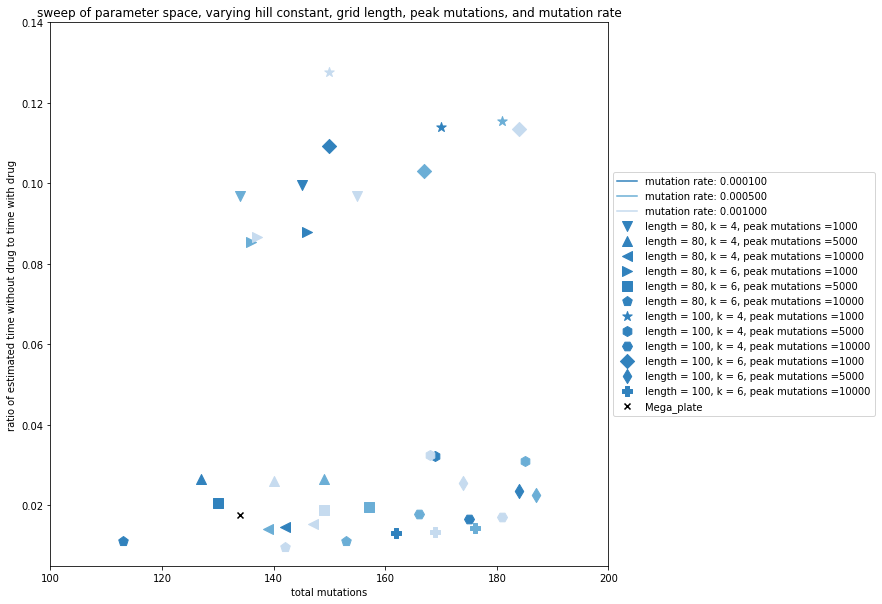

In [122]:
fig, ax  = plt.subplots(figsize=(10,10))
ax.set_ylim(0.005,.14)
ax.set_xlim(100,200)
filled_markers = ('o', 'v', '^', '<', '>'
                  , 's', 'p', '*', 
                  'h', 'H', 'D', 'd', 'P', 'X')

colors =  plt.cm.tab20c( (4/8*np.arange(24*8/4)).astype(int) )

i = 0 
for a in ln :
    for b in k :
        for c in pk:
            i = i+1
            for d in range(len(mut_rate)):
                try:
                    df_134[df_134['length']==a][df_134['k']==b][df_134['pk']==c][df_134['mut_rate']==mut_rate[d]].plot('muts', 'time_ratio',
                                                                                      kind = 'scatter',ax=ax,
                                                                                     marker = filled_markers[i],s =100,
                                                                                      label='length = {0}, k = {1}, peak mutations ={2}'.format(a,b,c) if d ==0 else None,
                                                                                                      color = colors[d*3])
                    
                except:
                    None

plt.scatter(134,mp_swarm_time/mp_exp_time, marker = 'x',color = 'k', label = 'Mega_plate' )
for d in range(len(mut_rate)):
    plt.plot(d, label = 'mutation rate: %f' % mut_rate[d], color =colors [d*3])

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('total mutations')
ax.set_ylabel('ratio of estimated time without drug to time with drug')
plt.title('sweep of parameter space, varying hill constant, grid length, peak mutations, and mutation rate')

The above parameter sweep reveals an underfitting of parameters to determine the mutations rate. To remedy this, k can be further contrained to replicate the dynamics of the megaplate

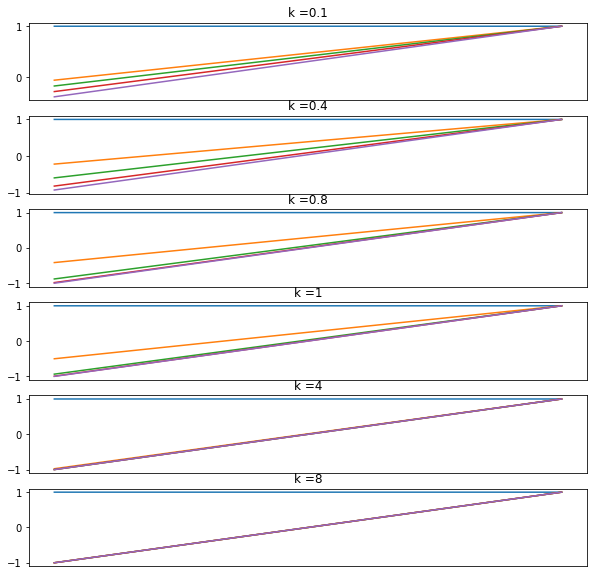

In [68]:
%matplotlib inline
pk = 10000
fig, axs = plt.subplots(6,1,figsize=(10,10))
gr=5
k = [ .1,.4,.8,1,4,8]
for j in range(len(k)):
    ax = axs[j]
    for i in range(gr):
        #sub_axs.append(fig.add_subplot(gs1[i +1, 0]))

        #plt.set_yticks([0,1])
        #plt.ylim(bottom=0,top=1)
        ax.set_xticks([])
        ax.plot(np.linspace(0,pk,pk+1),
                fitness(np.unique(abx_grad)[i],
                          np.linspace(0,pk,pk+1),k[j],-1,1,pk),label = np.unique(abx_grad)[i])
        ax.set_title('k =' + str(k[j]))
    
#plt.legend()

By observing the megaplate experiment we get a qualitative sense that each subsequent increase in antiboitics causes a change in the fitness landscape signifigant enought to cause the growth front to 'pause' before growing again. We can conatrsin the value of k to provide a signfigant enough difference in fitness that qualitiatlve yhtis 'pausing' dynamic is recaputatiled. Likely at the values of k sampled above, this is not occuring 

In [94]:
plt.cm

<module 'matplotlib.cm' from '/Users/krishnn/anaconda3/lib/python3.6/site-packages/matplotlib/cm.py'>

In [82]:
is_nice = True
state = "nice" if True else "not nice"

In [27]:
pk

[1000, 5000, 10000]

In [63]:
%%time 

ln = 100
wd = int(.9 *ln)
gr = 5

l = [val for sublist in [[j for i in range(int(ln/gr))] for j in range (0,gr)] for val in sublist]
ab =[[3*10**(i-1)]*wd for i  in l if i != 0]
[ab.insert(i, [0]*wd) for i in range(0,int(ln/gr))]
abx_grad = np.array(ab)

ch1,mp = sim_user_abx(wt = wd,ln =ln,g= gr, ab = abx_grad ,mut_rate=.001,k = 1, s_p = -1,s = 1, pk= 100)

CPU times: user 34.2 s, sys: 137 ms, total: 34.3 s
Wall time: 34.5 s


In [66]:
np.array(ch1[-1]).max()


13

In [67]:
100/len(ch1)

0.15748031496062992

In [64]:
plt.imshow(ch1[-1])

In [54]:
%matplotlib qt
fig =plt.figure(figsize=(6,11))


cellhistory = ch1

ims = []
ax1 = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(1, 2, 1)


#Phylo.draw(t1,label_func =lambda n: None, branch_labels=lambda n: None,axes=ax2)
norm = colors.Normalize(vmin=-2, vmax=max(max(max(cellhistory))))
hi = ax1.imshow(np.array(cellhistory[-1]).T,interpolation='nearest', origin='lower',norm=norm,cmap='YlGnBu');
for i in range(len(cellhistory)):
    
    ims.append((ax1.imshow(np.array(cellhistory[i]).T, interpolation='nearest', origin='lower',norm=norm,cmap='YlGnBu'),))

    plt.grid(False)
    plt.axis('Off')
    plt.title('Mega Plate CA')
    

cbar = fig.colorbar(hi,ax=ax1, orientation = 'horizontal')

cbar.set_ticks([-1,max(max(max(cellhistory)))])
cbar.set_ticklabels(["Low ",'High'])

cbar.set_label("mutational dist. from WT") 
im_ani = animation.ArtistAnimation(fig, ims,interval=100, repeat_delay=1000,
                                   blit=True)



plt.show()
#im_ani.save('MegaPLate_CA_tree.gif', writer='imagemagick')


In [5]:
def fit(d,k,p,s):
    #p = s - s_p
    y =p*((d**k)/((d**k)- (s-p)/s))
    return y

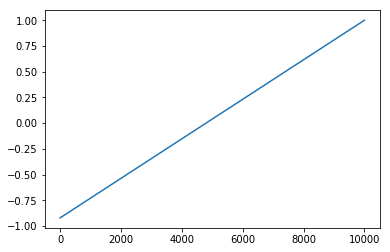

In [17]:
t = np.linspace(0,10000,10001)
plt.plot(t,fitness(3000,t,.4,2,1,10000))


In [69]:
poisson_max_cdf([0,1,2,3,4,5,6],.001,36*40)*

array([0.23692776, 0.99928074, 0.99999976, 1.        , 1.        ,
       1.        , 1.        ])

In [ ]:

for i in np.unique(abx_grad):
    bias_mut_dist =  (fitness(i,t,k,s_p,s,pk)+1)/2

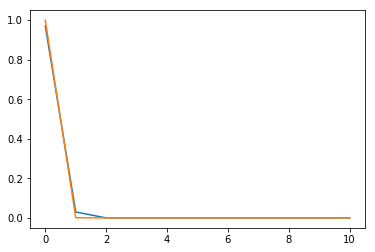

In [13]:
k = 0

s_p = -1
s =1 
pk= 100
mut_rate=.001
#new 
t = np.linspace(0,pk,pk+1)
poisson_unbias = poisson.pmf(t,mut_rate)
bias_mut_dist=[]
poisson_biased = []
for i in np.unique(abx_grad):
    poisson_biased.append((poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))/(sum(poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))))

plt.plot(poisson_biased[4][0:11])

k = .1
s_p = -1
s =1 
pk= 100
mut_rate=.001
#new 
t = np.linspace(0,pk,pk+1)
poisson_unbias = poisson.pmf(t,mut_rate)
bias_mut_dist=[]
poisson_biased = []
for i in np.unique(abx_grad):
    poisson_biased.append((poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))/(sum(poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))))

plt.plot(poisson_biased[4][0:11])


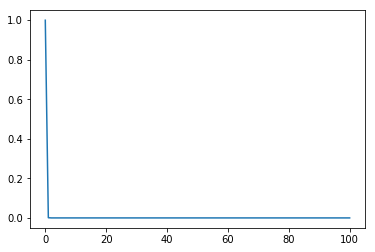

In [186]:
plt.plot(poisson_biased[0])


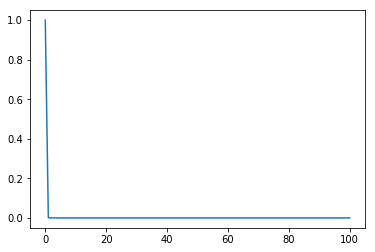

In [30]:
plt.plot(poisson_biased[np.where( 3== np.unique(abx_grad))[0][0]])

In [50]:
pk =1000
k=3
s_p= -1
s=1

t = np.linspace(0,pk,pk+1)
poisson_unbias = poisson.pmf(t,mut_rate)
poisson_biased=[]
for i in np.unique(abx_grad):
    (fitness(i,t,k,s_p,s,pk)+1)/2
    poisson_biased.append((poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))/(sum(poisson.pmf(t,mut_rate)*((fitness(i,t,k,s_p,s,pk)+1)/2))))
m = np.random.choice(t,1,p = poisson_biased[np.where(3000== np.unique(abx_grad))[0][0]])

In [51]:
m

array([1.])

In [47]:
poisson_biased

[array([9.9900050e-01, 9.9900050e-04, 4.9950025e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]),
 array([9.98997503e-01, 1.00199450e-03, 5.02495744e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([9.98970531e-01, 1.02893965e-03, 5.29454381e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([9.98700890e-01, 1.29831116e-03, 7.98960712e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([9.96012462e-01, 3.98404985e-03, 3.48604362e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00])]

In [37]:
(sum(poisson.pmf(t,mut_rate)*(bias_mut_dist)))

array([1.28462828e+00, 1.28833865e-03, 6.46024512e-07, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])